In [14]:
from datetime import datetime
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pymongo
import numpy as np 
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D

Fonctions optimisant le calcul du score de silhouette

In [15]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed

def multi_core_kmeans_with_silhouette(data, n_clusters, cores=6):
    # Fit the KMeans model on the training data
    model = KMeans(n_clusters=n_clusters, n_init=10)
    model.fit(data)

    # Define the number of subsets to create and the number of workers
    num_subsets = cores
    num_workers = cores  # Number of CPU cores

    # Get the indices of the training data
    train_indices = np.arange(data.shape[0])

    # Calculate the size of each subset
    subset_size = len(train_indices) // num_subsets

    # Split the indices into subsets
    subsets = [train_indices[i * subset_size:(i + 1) * subset_size] for i in range(num_subsets)]

    # Define the function to compute silhouette score on a subset of data
    def compute_silhouette_score(data_subset):
        return silhouette_score(data[data_subset], model.labels_[data_subset])

    # Initialize the parallelization framework
    pool = Parallel(n_jobs=num_workers)

    # Compute silhouette scores in parallel
    results = pool(delayed(compute_silhouette_score)(subset) for subset in subsets)

    # Aggregate the results
    return model, sum(results) / len(results)


# Récupération des données

In [16]:
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client["Tweet"]
user_collection = db["users"]

## Suppression des colonnes non utilisées lors du kmeans
On retire toutes les colonnes qui ne sont pas des attributs de nos utilisateurs.  
De plus supprime l'attribut tweet_frequency de nos données sachant qu'il est corrélé avec l'agressivité. Ce paramètre n'apporte pas d'informations supplémentaires. Une visualisation de cette corrélation peut être observée dans le script ``previewData``

In [17]:
users = list(user_collection.find({}))
users = pd.DataFrame(users)
users.index = users.user_id
users = users.drop(columns=["_id","user_id","last_tweet_published_id","tweet_ids","friends_count","followers_count","tweet_frequency"])
users.head()

,hashtag_frequency,verified,statuses_count,favourites_count,age_account,ratio_friends_followers,avg_tweet_length,nb_sensitive_tweets,Ap,visibility,ratio_sensitive_tweets,ratio_punctuation_tweets,avg_tweet_levenshtein_similarity
user_id,,,,,,,,,,,,,
39084553,0.08,0,0.003611,0.010133,0.187854,0.000835,0.321867,0.0,0.003526,0.190383,0.0,0.069565,0.000000
1564678657,0.00,0,0.003194,0.008968,0.102295,0.000587,0.103194,0.0,0.005729,0.000000,0.0,0.158397,0.000000
4872447178,0.07,0,0.000580,0.000084,0.048922,0.000718,0.309582,0.0,0.002178,0.157138,0.0,0.046377,0.276906
967244973824339968,0.00,0,0.000475,0.001242,0.006415,0.000771,0.068796,0.0,0.013588,0.037790,0.0,0.214367,0.104260
35628099,0.08,0,0.000055,0.000654,0.188627,0.003186,0.321867,0.0,0.000053,0.265963,0.0,0.069565,0.000000


In [18]:
users.describe()

,hashtag_frequency,verified,statuses_count,favourites_count,age_account,ratio_friends_followers,avg_tweet_length,nb_sensitive_tweets,Ap,visibility,ratio_sensitive_tweets,ratio_punctuation_tweets,avg_tweet_levenshtein_similarity
count,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06,1.843439e+06
mean,5.952305e-02,9.808299e-03,1.984750e-03,5.092404e-03,9.806041e-02,1.254561e-03,2.431186e-01,1.256115e-04,4.325829e-03,1.539910e-01,9.341535e-03,7.798288e-02,1.062628e-01
std,5.663139e-02,9.854999e-02,4.545999e-03,1.281933e-02,5.866958e-02,2.585816e-03,7.733582e-02,2.744774e-03,1.072405e-02,9.819461e-02,9.089836e-02,4.253557e-02,1.556571e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e-02,0.000000e+00,1.238742e-04,2.577807e-04,4.612570e-02,5.691263e-04,1.941032e-01,0.000000e+00,4.174320e-04,7.558016e-02,0.000000e+00,4.809343e-02,0.000000e+00
50%,4.000000e-02,0.000000e+00,5.842191e-04,1.258645e-03,1.041309e-01,7.381097e-04,2.555283e-01,0.000000e+00,1.420996e-03,1.329816e-01,0.000000e+00,7.069943e-02,0.000000e+00
75%,8.000000e-02,0.000000e+00,2.008155e-03,4.608048e-03,1.459279e-01,1.223739e-03,3.206388e-01,0.000000e+00,4.226457e-03,1.903830e-01,0.000000e+00,1.019763e-01,2.757848e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.510615e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Standardisation des données via sklearn

In [19]:
scaler = StandardScaler()
user_scale = pd.DataFrame(scaler.fit_transform(users), columns = users.columns)

## Réalisation de l'ACP

In [20]:
pca = PCA()

In [21]:
result = pca.fit_transform(user_scale)

Stockage du résultat de l'ACP dans un dataframe avec les noms de colonnes CP1, CP2... CP1 = composante 1

In [22]:
n,m = users.shape
liste = []
for i in range(1,14):
    liste.append(f"CP{i}")
result = pd.DataFrame(result, columns = liste)

Détermination des valeurs propres


In [23]:
variance = pca.explained_variance_
variance

array([2.06463169, 1.97178157, 1.50375988, 1.32532279, 1.18800639,
       0.9767516 , 0.94629921, 0.85120946, 0.73326972, 0.64366425,
       0.37402712, 0.29226793, 0.12901543])

In [24]:
sum(variance)

13.00000705203762

 Bien que nous somme dans un ACP normé, la somme des valeures propres n'est pas egale à `13` car les la variance calculé avec le module `PCA` est celle donnée par l'estimateur sans biais  definie par la formule $\sigma^2 = $
 Un ajustement est nécessaire pour avoir la variance avec n degrés de liberté.

In [25]:
# Un ajustement est nécessaire pour avoir la variance avec n degrés de liberté
eigval = variance*(len(user_scale)-1)/len(user_scale)  
print(eigval)
print(f"Et on a la somme des valeures propre egale  à :{np.sum(eigval, axis =0)}")

[2.06463057 1.9717805  1.50375907 1.32532207 1.18800575 0.97675107
 0.9462987  0.851209   0.73326933 0.6436639  0.37402691 0.29226777
 0.12901536]
Et on a la somme des valeures propre egale  à :12.999999999996813


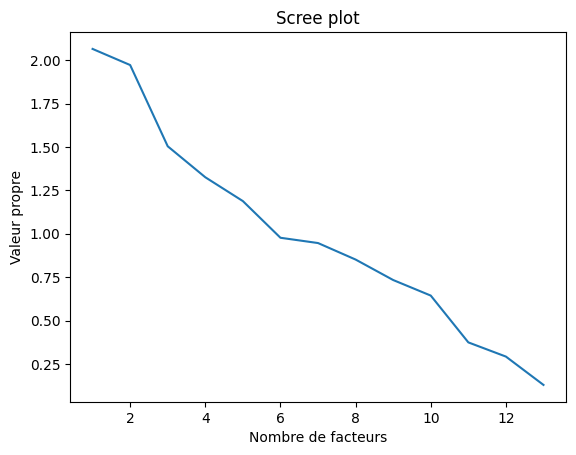

In [26]:
# Scree plot : éboulis des valeurs propres
plt.plot(np.arange(1,m+1),eigval)
plt.title("Scree plot")
plt.ylabel("Valeur propre")
plt.xlabel("Nombre de facteurs")
plt.show()

Réprésentation des composantes suites à l'ACP

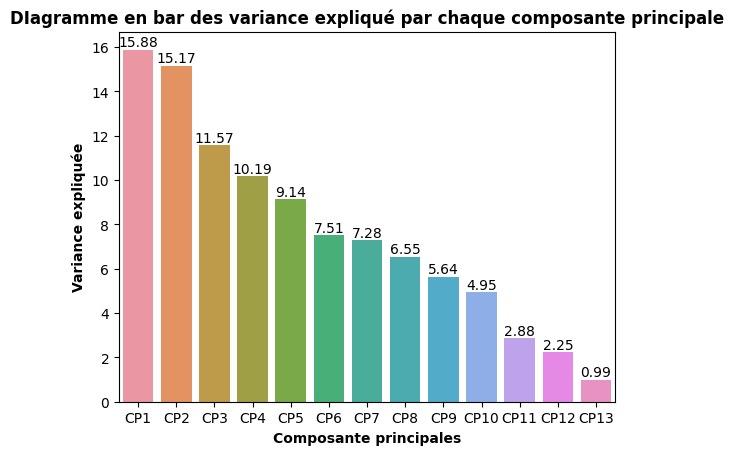

In [27]:
#ratio de la variance expliqué est % vaut 
sns.barplot(
    y = pca.explained_variance_ratio_*100,
    x = liste
)
for i, v in enumerate(pca.explained_variance_ratio_*100):
    plt.text(i, round(v,2), str(round(v,2)), ha='center', va='bottom')
plt.title("DIagramme en bar des variance expliqué par chaque composante principale", fontweight = "bold")
plt.xlabel("Composante principales", fontweight = "bold")
plt.ylabel("Variance expliquée", fontweight = 'bold')
plt.show()

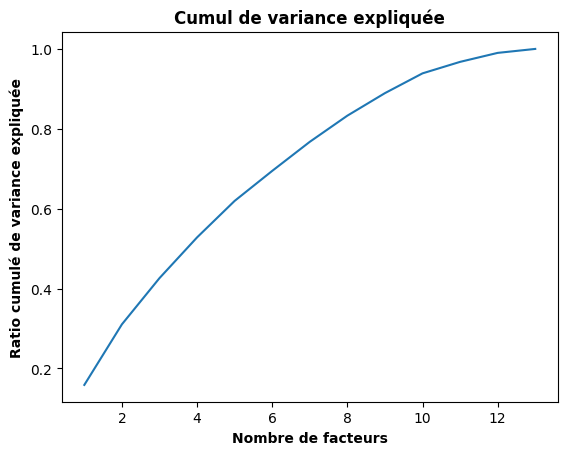

In [28]:
plt.plot(np.arange(1,m+1),np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumul de variance expliquée", fontweight = "bold")
plt.ylabel("Ratio cumulé de variance expliquée" , fontweight = "bold")
plt.xlabel("Nombre de facteurs" , fontweight = "bold")
plt.show()

# ACP  en tenant en compte que de 8 Composantes Principales

In [29]:
acp = PCA(n_components=10)

In [30]:
corr = acp.fit_transform(users)

In [31]:
#X_train, X_test =  train_test_split(corr, train_size=0.02)

In [32]:
%%time
models = []
score_inertie =[]
score_silhoutte = []
n_cluster = range(2,10)
for k in n_cluster:
    start_time = datetime.now()
    print(f"{'-'*30}\n>>>> Start cluster k = {k}: {start_time}")

    model,score = multi_core_kmeans_with_silhouette(corr,k)
    model.fit(corr)
    score_inertie.append(model.inertia_)
    score_silhoutte.append(score)
    models.append(model)

    end_time = datetime.now()         
    print(f"End : {end_time}")
    diff_time = end_time - start_time
    print(f"Duration : {diff_time.seconds // 3600}h {(diff_time.seconds // 60) % 60}min {diff_time.seconds % 60}sec ")
    


------------------------------
>>>> Start cluster k = 2: 2023-06-02 00:04:59.190057
End : 2023-06-02 00:50:34.691025
Duration : 0h 45min 35sec 
------------------------------
>>>> Start cluster k = 3: 2023-06-02 00:50:34.702293
End : 2023-06-02 01:35:08.315645
Duration : 0h 44min 33sec 
------------------------------
>>>> Start cluster k = 4: 2023-06-02 01:35:08.316645
End : 2023-06-02 02:19:53.547749
Duration : 0h 44min 45sec 
------------------------------
>>>> Start cluster k = 5: 2023-06-02 02:19:53.547749
End : 2023-06-02 03:04:48.987024
Duration : 0h 44min 55sec 
------------------------------
>>>> Start cluster k = 6: 2023-06-02 03:04:48.987024
End : 2023-06-02 03:49:35.296906
Duration : 0h 44min 46sec 
------------------------------
>>>> Start cluster k = 7: 2023-06-02 03:49:35.296906
End : 2023-06-02 04:34:22.641552
Duration : 0h 44min 47sec 
------------------------------
>>>> Start cluster k = 8: 2023-06-02 04:34:22.642552
End : 2023-06-02 05:19:07.589709
Duration : 0h 44min

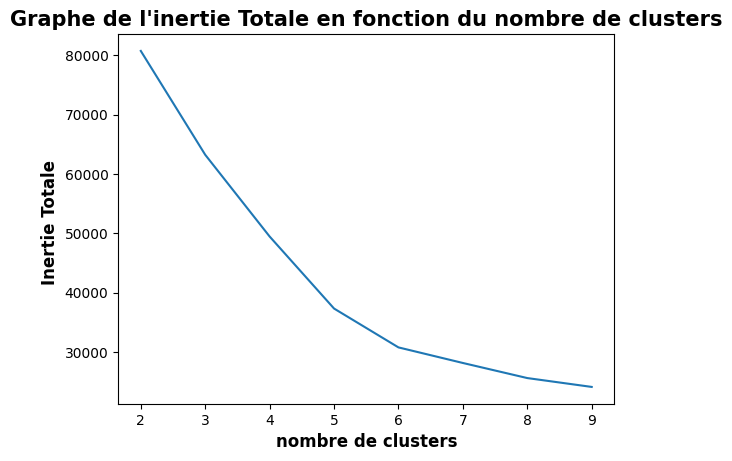

In [33]:
plt.plot(n_cluster, score_inertie)
plt.xlabel("nombre de clusters", fontweight = "bold",fontsize = 12)
plt.ylabel("Inertie Totale ", fontweight = "bold",fontsize = 12)
plt.title("Graphe de l'inertie Totale en fonction du nombre de clusters", fontweight = "bold", fontsize = 15)
plt.show()

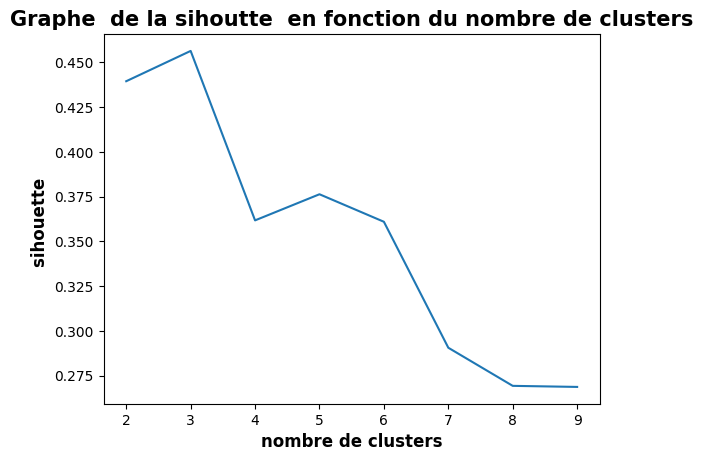

In [34]:
plt.plot(n_cluster, score_silhoutte)
plt.xlabel("nombre de clusters", fontweight = "bold",fontsize = 12)
plt.ylabel("sihouette ", fontweight = "bold",fontsize = 12)
plt.title("Graphe  de la sihoutte  en fonction du nombre de clusters", fontweight = "bold", fontsize = 15)
plt.show()

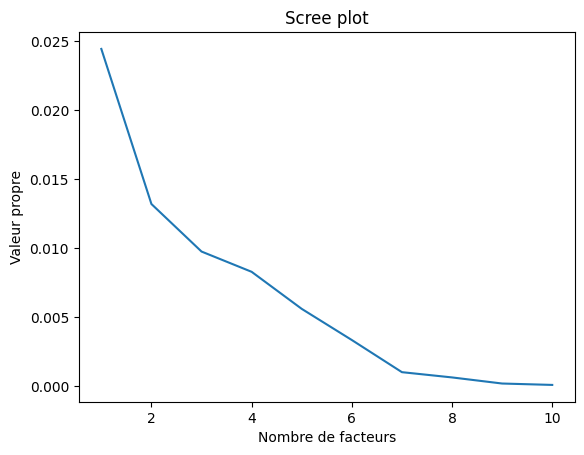

In [35]:
# Scree plot : éboulis des valeurs propres
valeurs_popres = acp.explained_variance_*(len(user_scale)-1)/len(user_scale)
plt.plot(np.arange(1,11),valeurs_popres)
plt.title("Scree plot")
plt.ylabel("Valeur propre")
plt.xlabel("Nombre de facteurs")
plt.show()

In [36]:
li = []
for i in range(1,11):
    li.append(f"CP{i}")

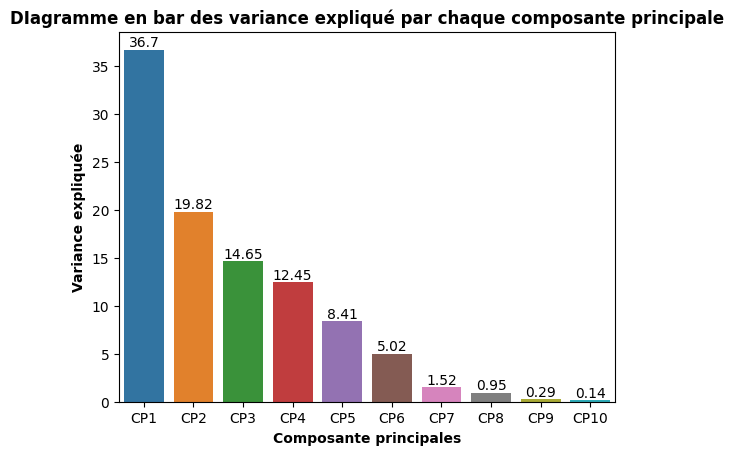

In [37]:
#ratio de la variance expliqué est % vaut 

sns.barplot(
    y = acp.explained_variance_ratio_*100,
    x = li
)
for i, v in enumerate(acp.explained_variance_ratio_*100):
    plt.text(i, round(v,2), str(round(v,2)), ha='center', va='bottom')
plt.title("DIagramme en bar des variance expliqué par chaque composante principale", fontweight = "bold")
plt.xlabel("Composante principales", fontweight = "bold")
plt.ylabel("Variance expliquée", fontweight = 'bold')
plt.show()

In [38]:
acp.explained_variance_ratio_*100

array([36.7024619 , 19.82439713, 14.65228119, 12.44641795,  8.41379549,
        5.02292477,  1.52476356,  0.95282751,  0.28918122,  0.13720469])

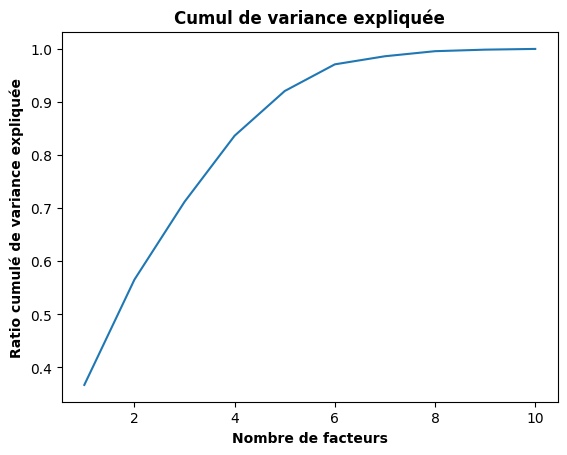

In [39]:
plt.plot(np.arange(1,11),np.cumsum(acp.explained_variance_ratio_))
plt.title("Cumul de variance expliquée", fontweight = "bold")
plt.ylabel("Ratio cumulé de variance expliquée" , fontweight = "bold")
plt.xlabel("Nombre de facteurs" , fontweight = "bold")
plt.show()

In [40]:
# Nous avons besoin des vecteurs propres pour l’analyse des variables.
# on récupère le champ components_ de l'objet ACP 
# Attention acp.components retourne la matrice des vecteurs propres facteurs x variables
# il faut la transposer pour avoir la matrice des vecteurs propres variables x facteurs  
vp_mat= acp.components_.T
vp_mat

array([[ 4.84941951e-02,  4.14432237e-01,  1.37037450e-02,
         3.43986746e-02,  2.63590429e-01,  3.27276844e-02,
        -1.50363597e-02, -8.66717096e-01,  5.03591553e-02,
        -2.55901234e-03],
       [ 2.66703086e-02, -4.31336144e-02,  9.92148780e-01,
         6.06520035e-02,  3.60183089e-02, -8.90588339e-02,
        -1.04090914e-02,  6.71474120e-03, -3.89955420e-04,
        -2.51385152e-03],
       [ 3.30391940e-03, -1.39926358e-03,  2.83843117e-03,
         1.94318458e-03,  3.12325226e-04,  1.62803989e-02,
         2.01061040e-03,  1.29821206e-02,  1.89839199e-01,
         1.98716768e-01],
       [ 4.75576786e-03, -2.84502867e-03, -7.57311137e-04,
         2.21649548e-03, -7.44930653e-04,  1.20577105e-02,
        -2.65409478e-03,  4.92876040e-02,  8.35738760e-01,
        -5.44027881e-01],
       [ 2.67422539e-03, -7.22802667e-02,  8.38863334e-02,
         8.01421811e-03,  4.37126224e-02,  9.92064310e-01,
         2.15786631e-02,  1.72092003e-02, -5.10325786e-03,
         1.

In [41]:
# On calcule la racine carrée des valeurs propres
sqrt_eigval = np.sqrt(acp.explained_variance_*(len(user_scale)-1)/len(user_scale))
sqrt_eigval

array([0.15634461, 0.11490404, 0.0987843 , 0.09104529, 0.0748568 ,
       0.05783805, 0.03186666, 0.02519083, 0.01387779, 0.00955916])

In [42]:
# Corrélation des variables avec les axes
corvar = np.zeros((13,10))
for k in range(10):
     corvar[:,k] = vp_mat[:,k] * sqrt_eigval[k]

# Afficher la matrice des corrélations variables x facteurs
print(corvar)

[[ 7.58180588e-03  4.76199386e-02  1.35371486e-03  3.13183740e-03
   1.97315372e-02  1.89290545e-03 -4.79158576e-04 -2.18333217e-02
   6.98873849e-04 -2.44620115e-05]
 [ 4.16975891e-03 -4.95622658e-03  9.80087232e-02  5.52207942e-03
   2.69621550e-03 -5.15098930e-03 -3.31702985e-04  1.69149893e-04
  -5.41171994e-06 -2.40303119e-05]
 [ 5.16549980e-04 -1.60781039e-04  2.80392437e-04  1.76917809e-04
   2.33796683e-05  9.41626526e-04  6.40714396e-05  3.27030374e-04
   2.63454879e-03  1.89956562e-03]
 [ 7.43538656e-04 -3.26905290e-04 -7.48104509e-05  2.01801480e-04
  -5.57631281e-05  6.97394467e-04 -8.45771383e-05  1.24159558e-03
   1.15982081e-02 -5.20045022e-03]
 [ 4.18100718e-04 -8.30529470e-03  8.28665277e-03  7.29656835e-04
   3.27218722e-03  5.73790653e-02  6.87639938e-04  4.33514012e-04
  -7.08219476e-05  1.71747099e-04]
 [-2.54011553e-05  1.78270680e-04 -9.32168374e-05 -1.96823284e-05
  -5.88517903e-05 -3.83030754e-04  5.22788718e-06 -4.00893162e-05
  -1.76629047e-04 -2.01292302e-05

In [43]:
# On affiche les corrélations pour les deux premiers axes
pd.DataFrame(corvar, columns = li, index = users.columns)

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10
hashtag_frequency,0.007582,0.047620,0.001354,0.003132,0.019732,0.001893,-0.000479,-0.021833,0.000699,-0.000024
verified,0.004170,-0.004956,0.098009,0.005522,0.002696,-0.005151,-0.000332,0.000169,-0.000005,-0.000024
statuses_count,0.000517,-0.000161,0.000280,0.000177,0.000023,0.000942,0.000064,0.000327,0.002635,0.001900
favourites_count,0.000744,-0.000327,-0.000075,0.000202,-0.000056,0.000697,-0.000085,0.001242,0.011598,-0.005200
age_account,0.000418,-0.008305,0.008287,0.000730,0.003272,0.057379,0.000688,0.000434,-0.000071,0.000172
ratio_friends_followers,-0.000025,0.000178,-0.000093,-0.000020,-0.000059,-0.000383,0.000005,-0.000040,-0.000177,-0.000020
avg_tweet_length,0.012291,0.041645,0.005668,-0.006452,-0.062033,0.002966,0.012675,-0.002040,0.000044,-0.000036
nb_sensitive_tweets,0.000102,-0.000028,-0.000066,0.000965,-0.000089,0.000006,-0.000013,-0.000002,0.000043,0.000040
Ap,0.001214,0.000186,-0.000003,0.000288,-0.000278,-0.001036,0.000040,0.000660,0.007103,0.007790
visibility,0.014019,0.094326,0.002003,0.004160,0.018832,0.002375,-0.004588,0.012059,-0.000369,0.000005


On choisit x clusters grace au graph puis Plot 3 premieres colonnes de coor, 1 couleur par label
Faire 2nd ACP après kmeans et avant visu

In [67]:
corr_3D = corr[:,0:3]
corr_3D = np.c_[corr_3D,models[3].labels_]
labels = set(models[3].labels_)


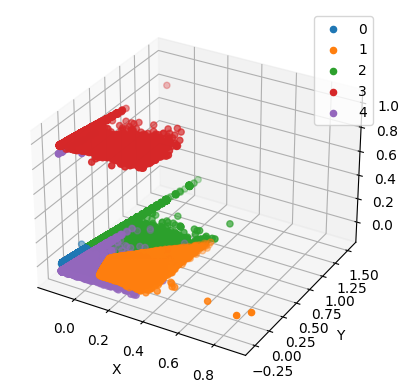

In [69]:
coordinates = corr_3D[:, :3]
colors = corr_3D[:, 3]


# Creating the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the points with the colors
for label in labels:
    plotted_values = corr_3D[:,3] == label
    ax.scatter(corr_3D[plotted_values,0], corr_3D[plotted_values,1], corr_3D[plotted_values,2], label = label)

# Setting labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()

# Displaying the plot
plt.show()

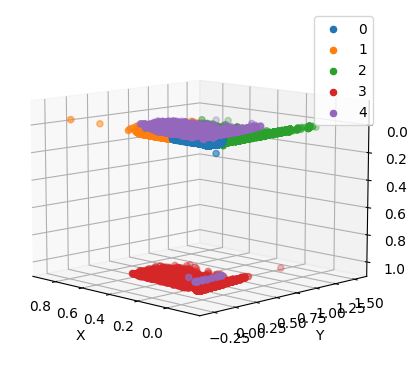

In [74]:
# Creating the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the points with the colors
for label in labels:
    plotted_values = corr_3D[:,3] == label
    ax.scatter(corr_3D[plotted_values,0], corr_3D[plotted_values,1], corr_3D[plotted_values,2], label = label)

# Setting labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()

ax.view_init(elev=190, azim=45)
# Displaying the plot
plt.show()

In [73]:
print("Nombre d'individus par label")
for label in labels:
    filtered_values = corr_3D[:,3] == label
    print(label," : ",np.count_nonzero(filtered_values))

Nombre d'individus par label
0  :  870733
1  :  556466
2  :  382030
3  :  18063
4  :  16147
